In [2]:
from selfAttention import SelfAttentionV2 ,SelfAttentionV1
import torch

# 3.5.1 Applying a causal attention mask 
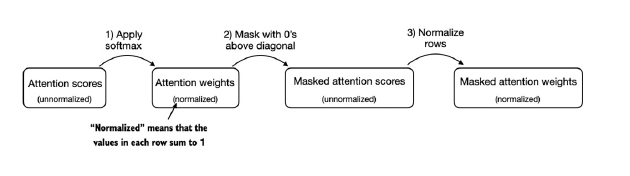


In [11]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

In [ ]:
# 1) Apply softmax
selfatt = SelfAttentionV2(3,2)
query = selfatt.w_queries(inputs)
key = selfatt.w_keys(inputs)
attention_score = query @ key.T
attention_weight = torch.softmax(attention_score / key.shape[-1]**0.5 , dim=-1)
attention_weight

In [15]:
# 2) mask wwith 0's above diagonal
context_len= attention_score.shape[0]
mask_simple =torch.tril(torch.ones(context_len,context_len))
mask_simple

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

In [16]:
masked_simple = attention_weight * mask_simple
masked_simple

tensor([[0.1679, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1682, 0.1697, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1682, 0.1699, 0.1700, 0.0000, 0.0000, 0.0000],
        [0.1674, 0.1674, 0.1675, 0.1651, 0.0000, 0.0000],
        [0.1682, 0.1738, 0.1735, 0.1599, 0.1616, 0.0000],
        [0.1672, 0.1651, 0.1653, 0.1668, 0.1715, 0.1642]],
       grad_fn=<MulBackward0>)

In [18]:
# 3) Normalize rows
row_sums =masked_simple.sum(dim=1,keepdim=True)
masked_simple_norm = masked_simple / row_sums
masked_simple_norm

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4978, 0.5022, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3310, 0.3344, 0.3346, 0.0000, 0.0000, 0.0000],
        [0.2507, 0.2509, 0.2510, 0.2474, 0.0000, 0.0000],
        [0.2009, 0.2076, 0.2073, 0.1911, 0.1930, 0.0000],
        [0.1672, 0.1651, 0.1653, 0.1668, 0.1715, 0.1642]],
       grad_fn=<DivBackward0>)

# Information leakage
When we apply a mask and then renormalize the attention weights, it might
initially appear that information from future tokens (which we intend to
mask) could still influence the current token because their values are part of
the softmax calculation

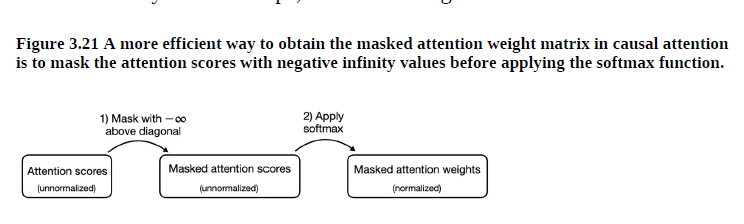

In [21]:

mask = torch.triu(torch.ones(context_len,context_len),diagonal=1)
masked = attention_score.masked_fill(mask.bool(),-torch.inf)
masked

tensor([[ 0.0790,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.1019,  0.1143,    -inf,    -inf,    -inf,    -inf],
        [ 0.1086,  0.1229,  0.1238,    -inf,    -inf,    -inf],
        [ 0.0324,  0.0332,  0.0340,  0.0132,    -inf,    -inf],
        [ 0.1982,  0.2444,  0.2426,  0.1272,  0.1415,    -inf],
        [-0.0274, -0.0452, -0.0431, -0.0303,  0.0086, -0.0530]],
       grad_fn=<MaskedFillBackward0>)

In [23]:
attention_weight = torch.softmax(masked / key.shape[-1]**0.5,dim=-1) 
attention_weight

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4978, 0.5022, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3310, 0.3344, 0.3346, 0.0000, 0.0000, 0.0000],
        [0.2507, 0.2509, 0.2510, 0.2474, 0.0000, 0.0000],
        [0.2009, 0.2076, 0.2073, 0.1911, 0.1930, 0.0000],
        [0.1672, 0.1651, 0.1653, 0.1668, 0.1715, 0.1642]],
       grad_fn=<SoftmaxBackward0>)

# 3.5.2 Masking additional attention weights with dropout

In [32]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
dropout(attention_weight)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0044, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6692, 0.0000, 0.0000, 0.0000],
        [0.5015, 0.5017, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4019, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3301, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

> When applying dropout to an attention weight matrix with a rate of 50%, half
of the elements in the matrix are randomly set to zero. To compensate for the
reduction in active elements, the values of the remaining elements in the
matrix are scaled up by a factor of 1/0.5 =2. This scaling is crucial to
maintain the overall balance of the attention weights, ensuring that the
average influence of the attention mechanism remains consistent during both
the training and inference phases.

In [33]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.1)
dropout(attention_weight)

tensor([[1.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5531, 0.5580, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3678, 0.3715, 0.3718, 0.0000, 0.0000, 0.0000],
        [0.2786, 0.2787, 0.2789, 0.2748, 0.0000, 0.0000],
        [0.2233, 0.2307, 0.2304, 0.2123, 0.0000, 0.0000],
        [0.1857, 0.1834, 0.1837, 0.1853, 0.1905, 0.1824]],
       grad_fn=<MulBackward0>)